In [7]:
using CairoMakie
using JLD2
using Oceananigans

[ Info: Oceananigans will use 4 threads


In [8]:
runnames = ["Ro08Ri000Ek0A15", "Ro08Ri001Ek0A15_1", "Ro08Ri010Ek0A15", "Ro08Ri020Ek0A15"]
runtitles = [L"0.0", L"0.01", L"0.1", L"0.2"];

In [84]:
@inline function VSP_with_depth(runname; resolution=(600, 400))
    foldername = "../scratch/filament-instability/$runname"
    vfilename = "down_front.jld2"
    filename = "down_front_mean.jld2"
    paramfilename = "parameters.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"])[101:end-1], file["serialized/grid"]
        end;
    xᶜᵃᵃ = xnodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    zᵃᵃᶠ = znodes(Face, grid)
    Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
    Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]

    function ∂z(v)
        let a = (circshift(v, (0, -1)) - circshift(v, (0, 1))) ./ (2Δzᵃᵃᶜ)
            a[:, 1] .= 0
            a[:, end] .= 0
            a
        end
    end
    
    sp = jldopen("$foldername/$paramfilename") do file
        file["parameters/simulation"]
    end
    vfile = jldopen("$foldername/$vfilename")
    file = jldopen("$foldername/$filename")
    fieldnames = [L"\partial_z \langle w'v'\rangle", "VSP", L"F_\psi"]
    function vwFLUX(frame)
        (vfile["timeseries/vwFLUX/$frame"][:, 1, 1:length(zᵃᵃᶜ)] .+ vfile["timeseries/vwFLUX/$frame"][:, 1, 2:length(zᵃᵃᶜ)+1]) / 2
    end
    
    function VSP(frame)
        return cumsum(Δzᵃᵃᶜ.*vwFLUX(frame); dims=2) .* ∂z(file["timeseries/v_dfm/$frame"][:, 1, :])
    end
    function ψforcing(frame)
        sp.f * cumsum(Δzᵃᵃᶜ.*vwFLUX(frame); dims=2)
    end
    
    ts = [file["timeseries/t/$f"] for f in frames] .- 1
    
    data = map(frames) do frame
        fields = [-vwFLUX(frame)[1:512, :], VSP(frame)[1:512, :], ψforcing(frame)[1:512, :]]
        [Δx * sum(field, dims=1)[1, :] for field in fields]
    end
    plot_data = [[data[i][f][j] for i in 1:length(frames), j in 1:length(zᵃᵃᶜ)] for f in 1:length(data[1])]
    title = "Ro=$(round(sp.Ro; digits=1)), Ri=$(round(sp.Ri; digits=2)), Ek=$(round(sp.Ek; digits=1))"

    axis_kwargs = (; xlabel="t", ylabel="z", title, limits=(ts[1], ts[end], -0.12, 0))
    return map(enumerate(plot_data)) do (i, data)
        fig = Figure(; resolution)
        ax = Axis(fig[1, 1]; axis_kwargs...)
        ht = heatmap!(ax, ts, zᵃᵃᶜ, data; colorrange=(-maximum(abs.(data)), maximum(abs.(data))), colormap=:balance)
        Colorbar(fig[1, 2], ht; label=fieldnames[i])
        fig
    end
end

VSP_with_depth (generic function with 1 method)

In [ ]:
fignames = ["vwFLUX", "VSP", "psiforcing"];
for runname in runnames
    figures = VSP_with_depth(runname)
    [save("output/figures/$figname$runname.png", fig) for (fig, figname) in zip(figures, fignames)];
end

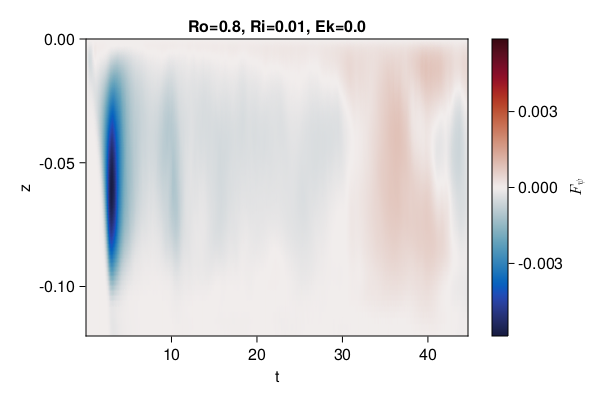

In [89]:
figures[3]